# Python and C++ extension

## Importing library

In [1]:
import sys
sys.path.append('../../CppToPython')

In [2]:
import numpy as np
import GeDiM4Py as gedim

### Initialize

In [3]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

## Non-Linear Equation 

**Recap** of what we did in theory during the Lesson n. 13.

Solving the following equation on square $\bar{\Omega} = [0, 1] \times [0, 1]$

$$
\begin{cases}
- \nabla \cdot (\nabla u) + u \nabla \cdot u = g & \text{in } \Omega\\
u = 0.0 & \text{in } ∂Ω \text{   homogeneous Dirichlet boundary condition}
\end{cases}
$$

where $u = 16 xy(1-x)(1-y)$.

The weak form of the problem becomes, find $u \in V := H^1_0(\Omega)$
$$
\int_{\Omega} \nabla u \nabla v + \int_{\Omega} u \nabla \cdot u v - \int_{\Omega} g v = 0 \quad \forall v \in V \Leftrightarrow f(u; v) := f_1(u; v) + f_2(u; v) + f_3(u; v) = 0 \quad \forall v \in V
$$

Using **Newton schema**, we solve for each $k$ iteration the problem
$$
J_f [\partial u]_{|_{u_k}} = - f(u_k; v) = 0 \quad \forall v \in V
$$
where $J_f [\partial u]_{|_{u_k}}$ is the evaluation of the derivative (Jacobian) of $J_f$ in the point $u_k$ along the unknown direction of $\partial u$.

After computations, we find the linear system, on each $k$ iteration, fixed $u_k$ find $\partial u$ s.t.

$$
\int_{\Omega} \nabla \partial u \cdot \nabla v + \int_{\Omega} \nabla \cdot u_k \partial u \ v + \int_{\Omega} u_k \nabla \cdot \partial u \ v = - \int_{\Omega} \nabla u_k \cdot \nabla v - \int_{\Omega} \nabla u_k \cdot u_k \ v + \int_{\Omega} g v 
$$



### Algorithm: Newton's Method for Nonlinear PDEs

1.  **Input:**
    * Nonlinear PDE operator $R$
    * Tolerance $\epsilon$
    * Maximum iterations $m_{max}$
    * Initial guess $u_0$.
2.  **Output:** Approximate solution $u$.
3.  Initialize $m = 0$.
4.  Choose an initial guess $u_0$.

5.  **For** $m = 0, 1, 2, \dots, m_{max}-1$:
    *  Evaluate the residual $R(u_m)$.
        *Often in variational form: $F(u_m)(v)*
    *  Evaluate the linearized operator $R'(u_m)$.
        *Often in variational form: find $J_F[\cdot](\cdot)$*
    *  Solve the linear equation $R'(u_m)[\delta u_m] = -R(u_m)$ for the correction $\delta u_m$.
        *Often in variational form: $J_F[\delta u_m](v) = -F(u_m)(v)$*
    *  Update the solution: $u_{m+1} = u_m + \delta u_m$.
    *  Check for convergence.
    *  **If** $||R(u_{m+1})|| < \epsilon$ or $||\delta u_m|| < \epsilon$:
        -  Set $u = u_{m+1}$.
        -  **break** (Exit the loop)

6.  **If** $m == m_{max}-1$ and convergence not reached:
    **Warning:** Maximum number of iterations reached without convergence.
7.  Set $u = u_{m+1}$.

8.  **Return:** $u$.

In [ ]:
# points := list of quadrature points x_1, x_2, ..., x_q

# Do not depends on u_N, hence on the previous iteration
def Burger_a(numPoints, points): # Diffusion (1 integral in the math left part)
	values_a = np.ones(numPoints, order='F')
	return values_a.ctypes.data

def Burger_b(numPoints, points): # Advection
	values_b = np.ones((2, numPoints), order='F')
	return values_b.ctypes.data

def Burger_c(numPoints, points): # Reaction
	values_c = np.ones(numPoints, order='F')
	return values_c.ctypes.data

# Here in the code, every time that we see name_variable_non_linear, it means that the variable is related to the 
# non-linear part of the equation
# Then, this variable depends on u_N
def Burger_non_linear_b(numPoints, points, u, u_x, u_y): # Advection parameter related to the previous iteration
										# (3 integral in the math left part)
	vecu = gedim.make_nd_array(u, numPoints, np.double) # Evaluation of the function in some points
	values_nl_b = vecu
	return values_nl_b.ctypes.data

def Burger_non_linear_c(numPoints, points, u, u_x, u_y): # Reaction integral in which the parameter depends on u_N 
										# (2 integral ini the math left part)
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double) # Derivative of x := [d_x u_N|x_1, ..., d_x u_N|x_Q]
                    # Hence, it's an array that contains the derivarive wrt x of u_N computed in the different x_i
					# quadrature point
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double) # Derivative of y --> the same but wrt y
	values_nl_c = vecu_x + vecu_y # Summation of the derivative (this represents the "strange" divergence)
	return values_nl_c.ctypes.data

def Burger_f(numPoints, points): # Right hand side (3 integral in the math right part)
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_f = 32.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) + matPoints[0,:] * (1.0 - matPoints[0,:])) + \
	(16.0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:]) + \
	16.0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])) * \
	16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]))
	return values_f.ctypes.data

def Burger_non_linear_f(numPoints, points, u, u_x, u_y): 
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_f = vecu * (vecu_x + vecu_y)
	return values_nl_f.ctypes.data

def Burger_non_linear_der_f(numPoints, points, u, u_x, u_y):
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_d_f = np.zeros((2, numPoints), order='F')
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
	return values_nl_d_f.ctypes.data

def Burger_exactSolution(numPoints, points): # Exact solution u = 16 xy(1-x)(1-y)
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_ex = 16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]))
	return values_ex.ctypes.data

def Burger_exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

	if direction == 0:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:])
	elif direction == 1:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])
	else:
		values_ex_d = np.zeros(numPoints, order='F')

	return values_ex_d.ctypes.data

def Ones(numPoints, points):
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data

def OnesDerivative(numPoints, points):
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data

def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data

def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data

**Recap**

| Function                   | Represents                             | Mathematical Expression        |
|---------------------------|----------------------------------------|--------------------------------|
| `Burger_f`                | Source term `g`                        | `g(x, y)`                      |
| `Burger_non_linear_f`     | Nonlinear term                         | `u * div(u)`                  |
| `Burger_non_linear_der_f` | Derivative (w.r.t. u) of nonlinear term| `grad(u)` ≈ `[∂u/∂x, ∂u/∂y]`  |


### Define Simulation Parameters

Set geometry parameters

In [ ]:
meshSize = 0.01
order = 1

# Discrete space - finite element order 1
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 
          'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

Set Newton parameters

In [ ]:
# Variable using in the newton iteration
residual_norm = 1.0
solution_norm = 1.0;
newton_tol = 1.0e-6 # Tolerance for the stopping criteria
max_iterations = 7 # We do not know if the Newton Scheme converges or not --> stop at a certain point
                # Remember that Newton goverges iif the starting point is close enough to the solution 
num_iteration = 1

Set Initial Solution

In [ ]:
# Initialization of the guess of the solution --> the NM converges rapidly if we start not far away from the solution
u_k = np.zeros(problemData['NumberDOFs'], order='F') # Starting from 0, not a good idea to the speed of convergence
                            # Consider that for the project it's better to start from a better guess of the solution
        
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

### Run Newton Algorithm

Using a **relative tolerance**, we have to compute relative error (in notes)

In [ ]:
while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: # We select a relative tollerance!
                                                                                    # We have to compute relative error to evaluate that
    [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Burger_a, problemData, lib) # Linear

    # Non linear - we need the previuous iteration evaluation
    # Hence, here we have to add the parameters Burger_non_linear_c for the reaction 
    #                                           Burger_non_linear_b for the advection
    [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Burger_c, Burger_non_linear_c, u_k, u_strong, problemData, lib)
    [advection, advectionStrong] = gedim.AssembleNonLinearAdvectionMatrix(Burger_b, Burger_non_linear_b, u_k, u_strong, problemData, lib)

    # Right hand side of the function
        # Linear part
    forcingTerm_g = gedim.AssembleForcingTerm(Burger_f, problemData, lib)
        # Non linear part
    forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Burger_non_linear_f, u_k, u_strong, problemData, lib)
    forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Burger_non_linear_der_f, u_k, u_strong,
                                                                      problemData, lib)

    # Solving with the LU solver because we're in a generic setting (no idea of the structure of the matrix)
    du = gedim.LUSolver(stiffness + advection + reaction, \
            forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
            lib)
    
    u_k = u_k + du
    
    du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
    
    # Compute the error if we have the exact solution --> because we know the exact solution
    u_errorL2 = gedim.ComputeErrorL2(Burger_exactSolution, u_k, u_strong, lib)
    u_errorH1 = gedim.ComputeErrorH1(Burger_exactDerivativeSolution, u_k, u_strong, lib)

    # Compute the norm if we do not have the exact solution
    u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
    u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
    
    solution_norm = u_normL2;
    residual_norm = du_normL2;
    
    print("dofs", "h", "errorL2", "errorH1", "residual", "iteration", "max_iteration")
    print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(u_errorL2 / u_normL2), 
          '{:.16e}'.format(u_errorH1 / u_normH1), '{:.16e}'.format(residual_norm / u_normL2),
            '{:d}'.format(num_iteration), '{:d}'.format(max_iterations)) 
    
    num_iteration = num_iteration + 1

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 5.2260777660062499e-02 1.9159453441746624e-01 1.0000000000000000e+00 1 7
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 3.5051158056069606e-02 1.8309858647719299e-01 3.4100994920636923e-02 2 7
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 3.5050027767402056e-02 1.8309836416946049e-01 2.4831242817296458e-05 3 7
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 3.5050027765334148e-02 1.8309836416908298e-01 8.0326321390164110e-12 4 7


### Plot Solution

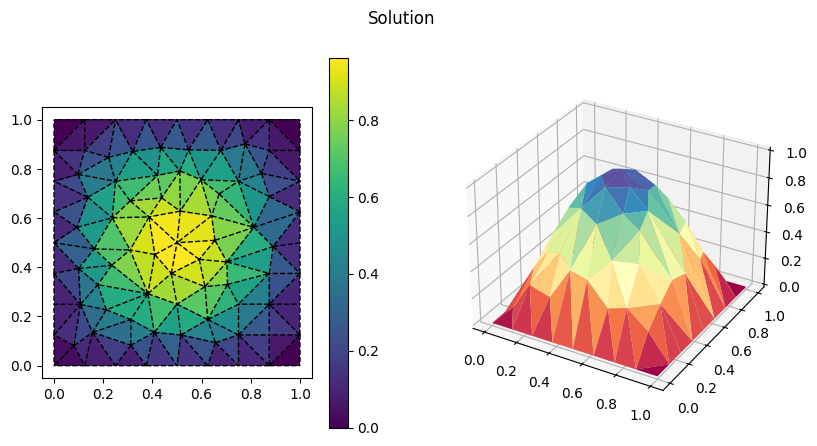

In [ ]:
# Plot and show the solution
gedim.PlotSolution(mesh, dofs, strongs, u_k, u_strong)
gedim.ExportSolution(Burger_exactSolution, u_k, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib) # To export solutions on paraview

# EvaluateSolutionOnPoints --> this function (taking from gedim) let you evaluate the solution, given the degree of fredom (u_k)
#  and u_strong, in all the point of the
# mesh (the tasselation), we need this quantity to evaluate the error, or using in the training phase of the NN 

# IMPORTANT FOR THE PROJECT: if you have a PINN, and you want to evaluate your PINN vs a finite element solution,
# you can use these points to do the comparison

# The quadrature formula is related to the order or your finite element
# The quadrature points are the points where you evaluate the solution, and the weights are the weights of the quadrature formula

# The higer is the degree of the finite element space, the more points you have in the quadrature formula

### Analysis of the function EXPORTSOLUTION & EXPORTSOLUTIONONPOINTS

Running these functions,
- **gedim.ExportSolution(Burger_exactSolution, u_k, u_strong, lib)**
- **gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib) # To export solutions on paraview** 
in the folder of the laboratory, appear two new folders: _Export_ and _Images_.

1. In **Images** folder appears the images of the plot, hence just the _.png_ of the plot that you can visualize in the cell above
2. In **Export** folder appear two different files in _.inp_ extention that export 2D and/or 3D geometric object
    - Solution_0
    - SolutionOnPOints_0

    Via these two files, exploint ParaView, we can study the solution in a different manner.

### Introduction to ParaView

#### What is ParaView?

**ParaView** is an open-source, multi-platform data analysis and visualization application. It is especially powerful for visualizing large scientific datasets, performing post-processing on simulation results, and creating interactive or high-quality visual outputs. Developed by Kitware, it supports a wide range of data formats and provides a rich set of tools for filtering, transforming, and rendering scientific data.

Key features:

* Supports structured and unstructured meshes
* Can visualize 2D and 3D data
* Includes a wide variety of filters for data manipulation
* Offers scripting support via Python
* Suitable for large-scale, parallel, and interactive visualization

---

#### Getting Started with ParaView

After you **download** ParaView from the official website ([https://www.paraview.org/download/](https://www.paraview.org/download/)), you can import your simulation data and begin analyzing it. Below is a brief workflow of what we can do in ParaView.

**What file do I need to download from the website?** `ParaView-5.13.3-Windows-Python3.10-msvc2017-AMD64.msi`

##### 1. Import the File

* Open the folder containing your data file (e.g. `Solution_0.inp`)
* Drag the file into the center of the ParaView application window
* Make sure to open it in **AVS mode** if prompted

##### 2. Initial Display

* Click **Apply** in the *Properties* panel (usually on the left)
* Click the **eye icon** (next to the file name in the pipeline browser) to make the data visible in the rendering view

##### 3. Change the Visualization Type

* You can modify how the solution is visualized:

  * Switch between **exact** and **numeric**
  * Change representation to `Surface`, `Surface with Edges`, `Wireframe`, etc., depending on the level of detail needed

##### 4. Working with Filters

ParaView includes a wide array of pre-implemented **filters** that allow you to post-process and manipulate your data.

* To add a filter:

  * Right-click the object in the *Pipeline Browser* or use the top menu: `Filters > Common` or `Filters > Alphabetical`
  * Alternatively, use the *filter button* at the top toolbar
* Filters allow you to:

  * Rotate and zoom into the solution in 3D
  * Slice through your data
  * Interpolate values
  * Calculate gradients, norms, and more

##### 5. Mesh and Solution Interpretation

In 2D:

* The mesh is displayed and the **color** corresponds to the **degree of freedom (DOF)** of each point in your numerical (high-fidelity) solution
* What you see is a **first-order (linear) interpolation** of the solution on the mesh
* The same applies to the **exact solution**: the values shown on the mesh are a first-order interpolation of the vertex data
* To get higher-order interpolations, you need to refine the mesh (i.e., increase the tessellation)

##### 6. Working with Exported Data

When exporting with `ExportSolution`, important variables to note:

* `u_strong`: Vertices of the boundary solution
* `exact_solution`: If not available, it returns a zero function

##### 7. Coloring Options in ParaView

You can choose how to apply coloring in the visualization:

* **Points**: Apply color values to nodes/vertices
* **Cells**: Apply color values to entire mesh cells (e.g., triangles)

Use the filter **Cell Data to Point Data** to convert a cell-based variable into point-based, which is often necessary for applying other filters (like `Delaunay 2D`).

---

#### Additional Tips

* To switch to 3D visualization:
  Go to **Properties** > **Scalars** and select `Numeric` to enable appropriate visualization.
* You can add **Gaussian points** for better resolution or sampling within elements.
* Always remember to hit **Apply** after adding a filter or modifying parameters.
* Use the *Color Map Editor* to change color scales, rescale to data range, or apply custom colormaps.

